In [89]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import scqubits as scq

Le but est de simuler avec différentes méthodes le hamiltonien suivant : 

$$\hat{H} = \left[ 4E_{C_T}\hat{n}_T^2 - E_J \cos(\hat{\varphi}_T) \right] \otimes \mathbb{I} 
+ \mathbb{I} \otimes \left( \hbar\omega(\hat{a}^\dagger\hat{a}) + \frac{1}{2} \right)
- 4E_{coupling} \hat{n}_T \otimes \left(i n_{ZPF}(\hat{a}^\dagger - \hat{a}) \right)$$

## Résolution SCQUBITS

In [90]:
def get_eigen_sc(
    EJ=30.02,
    EC_T=1.2,
    EC_R=0.01,
    EL_R=0.5,
    E_coupling=0.1,
    n_cut=31,
    osc_cut=10,
    N_eigen=3,
):
    omega = np.sqrt(8 * EC_R * EL_R)

    n_zpf = (EL_R / (32 * EC_R))**0.25

    transmon = scq.Transmon(EJ=EJ, EC=EC_T, ng=0.0, ncut=n_cut)

    oscillator = scq.Oscillator(E_osc=omega, truncated_dim=osc_cut)

    hilbert_space = scq.HilbertSpace([transmon, oscillator])

    n_T = transmon.n_operator()

    a = oscillator.annihilation_operator()
    adag = oscillator.creation_operator()

    n_R = n_zpf * 1j * (adag - a)

    hilbert_space.add_interaction(
        g=-4 * E_coupling, op1=(transmon.n_operator, transmon), op2=(n_R, oscillator)
    )


    vals = hilbert_space.eigenvals(evals_count=N_eigen + 1)
    vals = vals - vals[0]

    return vals[1:]

## Résolution qutip

In [91]:
def Hamiltonian_qutip(
    EJ=30.02,
    EC_T=1.2,
    EC_R=0.01,
    EL_R=0.5,
    E_coupling=0.1,
    n_cut=31,
    osc_cut=10,
):
    omega = np.sqrt(8 * EC_R * EL_R)
    n_zpf = (EL_R / (32*EC_R))**0.25

    dim = 2 * n_cut + 1
    n_list = np.arange(-n_cut, n_cut + 1)
    n_op = qt.Qobj(np.diag(n_list))

    op_couple = qt.tunneling(dim, 1)

    H_T = 4 * EC_T * n_op**2 - 0.5 * EJ * op_couple

    a = qt.destroy(osc_cut)
    H_R = omega * a.dag() * a
    n_R = n_zpf * 1j * (a.dag() - a)

    I_T = qt.qeye(dim)
    I_R = qt.qeye(osc_cut)

    return (
        qt.tensor(H_T, I_R)
        + qt.tensor(I_T, H_R)
        - 4 * E_coupling * qt.tensor(n_op, n_R)
    )

In [92]:
def get_eigen_qutip(
    EJ=30.02,
    EC_T=1.2,
    EC_R=0.01,
    EL_R=0.5,
    E_coupling=0.1,
    n_cut=31,
    osc_cut=10,
    N_eigen=3,
):
    Hamiltonian = Hamiltonian_qutip(EJ, EC_T, EC_R, EL_R, E_coupling, n_cut, osc_cut)
    evals = Hamiltonian.eigenenergies()
    vals = evals - evals[0]

    return vals[1 : N_eigen + 1]

## Résolution numpy

In [93]:
def Hamiltonian_numpy(
    EJ=30.02,
    EC_T=1.2,
    EC_R=0.01,
    EL_R=0.5,
    E_coupling=0.1,
    n_cut=31,
    osc_cut=10,
):
    diag = [4 * EC_T * i**2 for i in range(-n_cut, n_cut + 1)]
    diag_off = [-EJ / 2 for i in range(-n_cut, n_cut)]
    diag_on = [-EJ / 2 for i in range(-n_cut, n_cut)]
    H_T = np.diag(diag, k=0) + np.diag(diag_on, k=1) + np.diag(diag_off, k=-1)
    I_T = np.eye(2 * n_cut + 1)

    omega = np.sqrt(8 * EL_R * EC_R)
    n_zpf = (EL_R / (32 * EC_R)) ** 0.25
    a = np.zeros((osc_cut, osc_cut))
    for i in range(osc_cut - 1):
        a[i][i + 1] = np.sqrt(i + 1)
    a_dag = a.conj().transpose()
    H_R = omega * (a_dag @ a + 0.5 * np.eye(osc_cut))
    I_R = np.eye(osc_cut)
    n_R = n_zpf * 1j * (a_dag - a)

    H_tot = (
        np.kron(H_T, I_R)
        + np.kron(I_T, H_R)
        - 4 * E_coupling * np.kron(np.diag(np.arange(-n_cut, n_cut + 1), k=0), n_R)
    )

    return H_tot


In [94]:
def get_eigen_numpy(
    EJ=30.02,
    EC_T=1.2,
    EC_R=0.01,
    EL_R=0.5,
    E_coupling=0.1,
    n_cut=31,
    osc_cut=10,
    N_eigen=3,
):
    H = Hamiltonian_numpy(EJ, EC_T, EC_R, EL_R, E_coupling, n_cut, osc_cut)

    eigen_values_H = np.linalg.eigvalsh(H)

    energies = eigen_values_H - eigen_values_H[0]
    return energies[1 : N_eigen + 1]

In [95]:
def plot_transmon_readout(
    EJ_max,
    EC_T=1.2,
    EC_R=0.01,
    EL_R=0.5,
    E_coupling=0.1,
    n_cut=31,
    osc_cut=10,
    N_eigen=3,
):
    EJ_liste = np.linspace(0, EJ_max, 100)
    Res = np.zeros((N_eigen, 3, 100))
    i = 0
    for EJ in EJ_liste:
        E_sc = get_eigen_sc(EJ, EC_T, EC_R, EL_R, E_coupling,n_cut,osc_cut,N_eigen)
        E_qu = get_eigen_qutip(EJ, EC_T, EC_R, EL_R, E_coupling,n_cut,osc_cut,N_eigen)
        E_np = get_eigen_numpy(EJ, EC_T, EC_R, EL_R, E_coupling,n_cut,osc_cut,N_eigen)
        Res[:, :, i] = np.array([E_sc, E_qu, E_np]).T
        i += 1
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
    for i in range(N_eigen):
        ax1.plot(EJ_liste, Res[i][0][:], label=f"Niveau {i}")
        ax2.plot(EJ_liste, Res[i][1][:], label=f"Niveau {i}")
        ax3.plot(EJ_liste, Res[i][2][:], label=f"Niveau {i}")
    ax1.set(
        xlabel=r"$EJ$",
        ylabel=r"$E^{(n)}-E^{(0)}$ [GHz]",
        title="Résolution avec scqubits",
    )
    ax2.set(
        xlabel=r"$EJ$",
        ylabel=r"$E^{(n)}-E^{(0)}$ [GHz]",
        title="Résolution avec qubits",
    )
    ax3.set(
        xlabel=r"$EJ$",
        ylabel=r"$E^{(n)}-E^{(0)}$ [GHz]",
        title="Résolution avec numpy",
    )

    ax3.legend(
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
    )
    plt.tight_layout()
    plt.show()

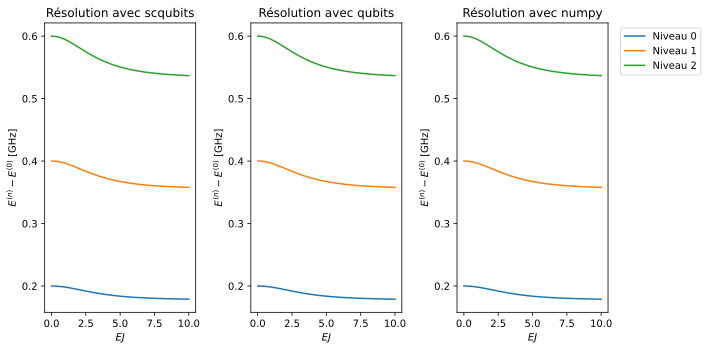

In [96]:
plot_transmon_readout(10)

## Reducing the hamiltonian related to the transmon

We are aiming to compute the coupled hamiltonian for the readout transmon for higher values of the readout cutoff. To do this, we will compute the Transmon eigenvectors alone, then inject them in the coupled hamiltonian.

We are starting from this hamiltonian : 
$$\hat{H} = \left[ 4E_{C_T}\hat{n}_T^2 - E_J \cos(\hat{\varphi}_T) \right] \otimes \mathbb{I} 
+ \mathbb{I} \otimes \left( \hbar\omega(\hat{a}^\dagger\hat{a}) + \frac{1}{2} \right)
- 4E_{coupling} \hat{n}_T \otimes \left(i n_{ZPF}(\hat{a}^\dagger - \hat{a}) \right)$$

Studying $\left[ 4E_{C_T}\hat{n}_T^2 - E_J \cos(\hat{\varphi}_T) \right]$ in the charge basis gives us the decomposition in the diagonale basis, $$\left[ 4E_{C_T}\hat{n}_T^2 - E_J \cos(\hat{\varphi}_T) \right] = \sum^{2*cutoff+1}_{i=0} \lambda_i |\psi_i \rangle \langle \psi_i| \quad \text{with} \quad |\lambda_i \rangle = \sum_{j=-cutoff}^{cutoff} c_{ij} | i \rangle$$

We will select the 4 lowest energies and extract a 4*4 matrix with them. Same for $\hat{n_t}$ that we will project on this 4 vector space.

In [97]:
def hamiltonian_transmon_numpy(
    EJ=30.02,
    EC_T=1.2,
    n_transmon = 4,
    n_cut = 500
):
    diag = [4 * EC_T * i**2 for i in range(-n_cut, n_cut + 1)]
    diag_off = [-EJ / 2 for i in range(-n_cut, n_cut)]
    diag_on = [-EJ / 2 for i in range(-n_cut, n_cut)]
    H_T = np.diag(diag, k=0) + np.diag(diag_on, k=1) + np.diag(diag_off, k=-1)
    return H_T


def hamiltonian_resonator_numpy(
    EC_R=0.01,
    EL_R=0.5,
    osc_cut=100,
):
    omega = np.sqrt(8 * EL_R * EC_R)
    n_zpf = (EL_R / (32 * EC_R)) ** 0.25
    a = np.zeros((osc_cut, osc_cut))
    for i in range(osc_cut - 1):
        a[i][i + 1] = np.sqrt(i + 1)
    a_dag = a.conj().transpose()
    H_R = omega * (a_dag @ a + 0.5 * np.eye(osc_cut))
    n_R = n_zpf * 1j * (a_dag - a)
    return H_R, n_R
    
    

In [98]:
def compute_transmon_diagonalization_basis(
    EJ=30.02,
    EC_T=1.2,
    n_transmon = 4,
    n_cut = 500
):
    H_T = hamiltonian_transmon_numpy(EJ, EC_T, n_transmon, n_cut)
    eigvals, eigvecs = np.linalg.eigh(H_T)

    n_t_charge_basis = np.diag([i for i in range(-n_cut,n_cut+1)])
    n_t_diag_basis = eigvecs.conj().T @ n_t_charge_basis @ eigvecs
    n_t_diag_basis = n_t_diag_basis[:n_transmon,:n_transmon]
    H_T_diag = np.diag(eigvals[:n_transmon])
    return H_T_diag, n_t_diag_basis, eigvecs, eigvals

In [99]:
def Hamiltonian_numpy_reduced(
    EJ=30.02,
    EC_T=1.2,
    EC_R=0.01,
    EL_R=0.5,
    E_coupling=0.1,
    n_transmon=4,
    n_cut = 500,
    osc_cut=100,
):
    H_T_diag, n_t_diag_basis, _, _ = compute_transmon_diagonalization_basis(EJ,EC_T,n_transmon,n_cut)  # noqa: E501
    I_T = np.eye(n_transmon)

    H_R, n_R = hamiltonian_resonator_numpy(EC_R,EL_R,osc_cut)
    I_R = np.eye(osc_cut)

    H_tot = (
        np.kron(H_T_diag, I_R)
        + np.kron(I_T, H_R)
        - 4 * E_coupling * np.kron(n_t_diag_basis, n_R)
    )

    return H_tot


In [100]:
def get_eigen_numpy_reduced(H,
    N_eigen = 3
):
    eigen_values_H = np.linalg.eigvalsh(H)

    energies = eigen_values_H - eigen_values_H[0]
    return energies[1 : N_eigen + 1]

In [105]:
def plot_transmon_readout_reduced(EJ_max,      
    EJ=30.02,
    EC_T=1.2,
    EC_R=0.01,
    EL_R=0.5,
    E_coupling=0.1,
    n_transmon=4,
    n_cut = 500,
    osc_cut=100,
    N_eigen=3,
):
    EJ_liste = np.linspace(0, EJ_max, 100)
    Res = np.zeros((N_eigen,2, 100))
    i = 0
    for EJ in EJ_liste:
        E_np_red = get_eigen_numpy_reduced(Hamiltonian_numpy_reduced(EJ, EC_T, EC_R, EL_R, E_coupling,n_transmon, n_cut,osc_cut),N_eigen)
        E_np = get_eigen_numpy(EJ, EC_T, EC_R, EL_R, E_coupling,31,10,N_eigen)
        Res[:, :, i] = np.array([E_np_red, E_np]).T
        i += 1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    for i in range(N_eigen):
        ax1.plot(EJ_liste, Res[i][0][:], label=f"Niveau {i}")
        ax2.plot(EJ_liste, Res[i][1][:], label=f"Niveau {i}")
    ax1.set(
        xlabel=r"$EJ$",
        ylabel=r"$E^{(n)}-E^{(0)}$ [GHz]",
        title="Résolution réduite avec numpy",
    )
    ax2.set(
        xlabel=r"$EJ$",
        ylabel=r"$E^{(n)}-E^{(0)}$ [GHz]",
        title="Résolution avec numpy",
    )

    ax2.legend(
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
    )
    plt.tight_layout()
    plt.show()

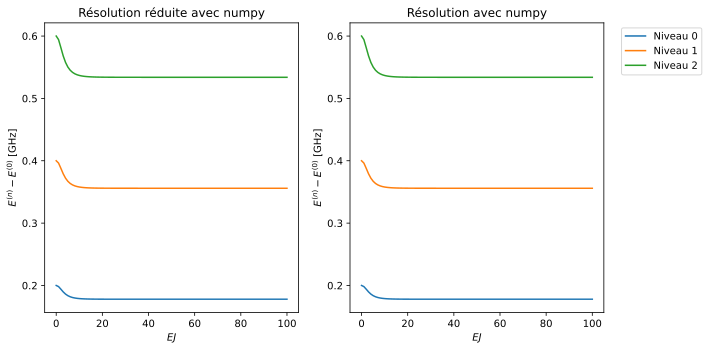

In [106]:
plot_transmon_readout_reduced(100)

In [109]:
import time

start_1 = time.perf_counter()
get_eigen_numpy_reduced(Hamiltonian_numpy_reduced(EJ=30.02,
    EC_T=1.2,
    EC_R=0.01,
    EL_R=0.5,
    E_coupling=0.1,
    n_transmon=4,
    n_cut = 100,
    osc_cut=100)
    ,3)
end_1 = time.perf_counter()

start_2 = time.perf_counter()
get_eigen_numpy(EJ=30.02,
    EC_T=1.2,
    EC_R=0.01,
    EL_R=0.5,
    E_coupling=0.1,
    n_cut = 100,
    osc_cut=100,
    N_eigen =3) 
end_2 = time.perf_counter()

print(f"Temps Version Reduced: {end_1 - start_1:.5f} secondes")
print(f"Temps Version Standard: {end_2 - start_2:.5f} secondes")

MemoryError: Unable to allocate 6.02 GiB for an array with shape (20100, 20100) and data type complex128